In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

### Calculate the energies

In [2]:
def calc_E(primals):
    orig_shape = primals.shape
    primals = primals.reshape((-1, 2))

    theta = primals[:,0]
    phi = primals[:,1]


    E = -jnp.sin(theta)*jnp.cos(phi)
    return E.reshape(orig_shape[0:-1])

## Exact calculation of $\Gamma$

In [3]:
gammas_momentum = np.load("gammas_momentum.npy")
gammas_natural = np.load("gammas_natural.npy")
kappas = np.load("kappas.npy")

E_nat = calc_E(gammas_natural)
E_momentum = calc_E(gammas_momentum)
N = gammas_momentum.shape[0]
N_iter = gammas_natural.shape[0]
iter = jnp.arange(N_iter)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


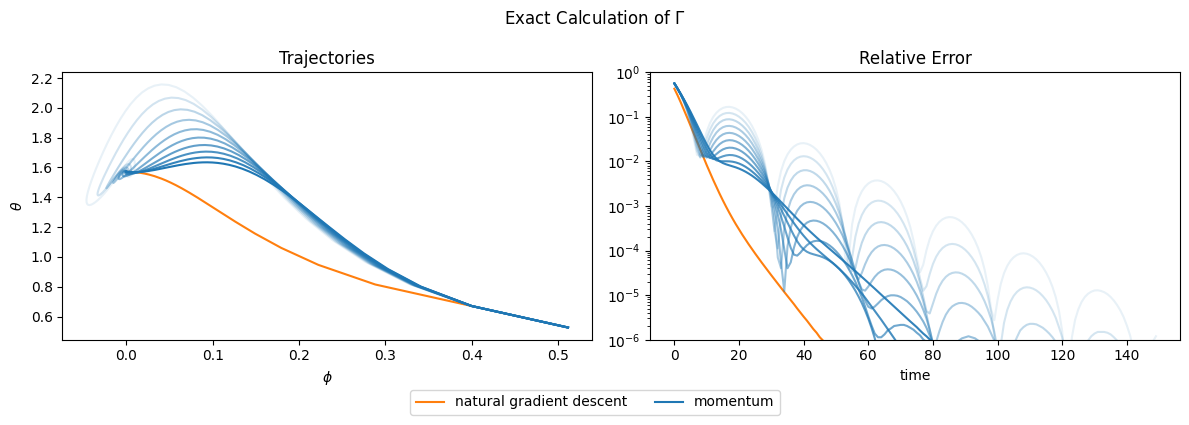

In [7]:
f, axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].plot(gammas_natural[:,1], gammas_natural[:, 0], color = "C1", label = "natural gradient descent")

for i in range(0, N):
    alpha = (i+1)/N

    if i == N-1:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", label = "momentum", alpha = alpha)

    else:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", alpha = alpha)

# axs[0].scatter(0, jnp.pi/2, color = "C3", marker = "o", zorder = 10)
# axs[0].set_ylim(0, jnp.pi)
# axs[0].set_xlim(-jnp.pi/3, 2/3*jnp.pi)
axs[0].set_ylabel("$\\theta$")
axs[0].set_xlabel("$\\phi$")
# axs[0].legend()
axs[0].set_title("Trajectories")

axs[1].plot(iter, E_nat+1, color = "C1")
for i in range(0, N):
    alpha = i/N*0.9 + 0.1
    axs[1].plot(iter, E_momentum[i]+1, color = "C0", label = "$\\kappa = $"+"{:.2f}".format(kappas[i]), alpha = alpha)

axs[1].set_yscale("log")
axs[1].set_title("Relative Error")
axs[1].set_ylim(1e-6,1)
axs[1].set_xlabel("time")

handles, labels = axs[0].get_legend_handles_labels()
f.legend(handles, labels, loc="lower center", ncol = 2, bbox_to_anchor = (0, -0.05, 1, 1))
f.suptitle("Exact Calculation of $\\Gamma$")

f.tight_layout()

## Approximated Calculation of $\Gamma$

As in high dimensional settings we would like to avoid taking derivatives of the metric, we employ approximations for the calculation of $b_{ljk}\dot{\gamma}^j\dot{\gamma}^k$:

$$
b_{ljk}\dot{\gamma}^j\dot{\gamma}^k = 2 \partial_j g_{lk}\dot{\gamma}^j\dot{\gamma}^k - \partial_l g_{jk}\dot{\gamma}^j\dot{\gamma}^k
$$

Defining $g_{ij}(t) = g_{ij}(\gamma(t))$, the first term is a total derivative:

$$
2 \partial_j g_{lk}\dot{\gamma}^j\dot{\gamma}^k = 2 (\dot{\gamma}^j \partial_j ) g_{lk}\dot{\gamma}^k =  2 \frac{d}{dt} g(t)_{lk} \dot{\gamma}^k
$$

This can be approximated as a first difference:

$$
2 \frac{d}{dt} g(t)_{lk} \dot{\gamma}^k \approx 2 \frac{1}{\epsilon} \left[g(t)_{lk} \dot{\gamma}^k - g(t - \epsilon)_{lk} \dot{\gamma}^k\right]
$$

This can be evaluated nicely as we store the past positions $\gamma$ and can evaluate $g$ along the way. Indeed, the second term is harder to approximate. Giving it a close look, we identify it as being the gradient of a scalar function. Without incorporating further information of the spatial dependece of $g$, we only now the above total derivative of g, or in other words the projection of the gradient of $g$ along $\dot{\gamma}$. As a result, we can at least incorporate the correct components of the gradient of $g$ along $\dot{\gamma}$. Thus we employ:
$$
\partial_l g_{jk}\dot{\gamma}^j\dot{\gamma}^k \approx \frac{d}{dt}g(t)_{jk}\dot{\gamma}^j\dot{\gamma}^k \frac{\dot{\gamma}^l}{\delta_{mn}\dot{\gamma}^m\dot{\gamma}^n} 
$$
Those two terms will be computed by the below functions $a$ and $b$ respectively.

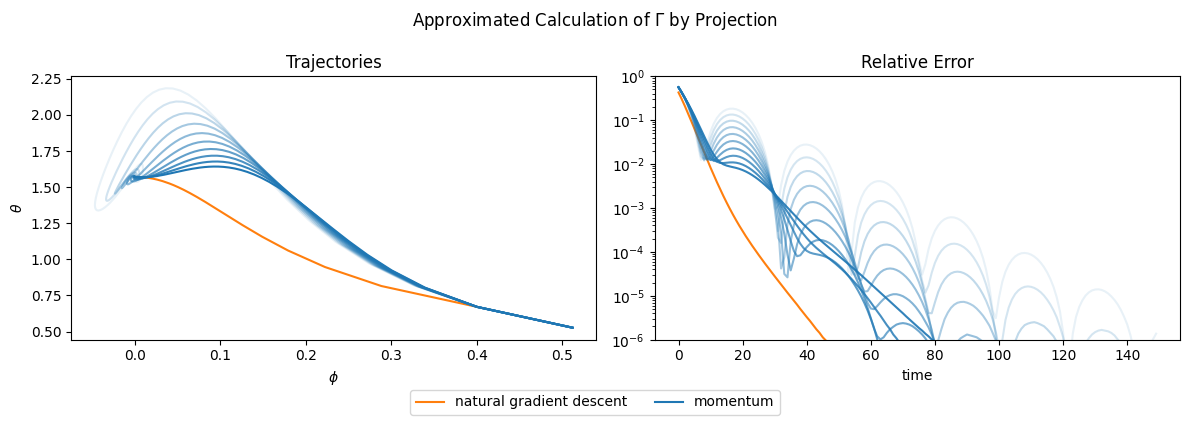

In [10]:
gammas_momentum = np.load("gammas_momentum_approx.npy")
gammas_natural = np.load("gammas_natural_approx.npy")
kappas = np.load("kappas_approx.npy")

E_nat = calc_E(gammas_natural)
E_momentum = calc_E(gammas_momentum)
N = gammas_momentum.shape[0]
N_iter = gammas_natural.shape[0]
iter = jnp.arange(N_iter)
f, axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].plot(gammas_natural[:,1], gammas_natural[:, 0], color = "C1", label = "natural gradient descent")

for i in range(0, N):
    alpha = (i+1)/N

    if i == N-1:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", label = "momentum", alpha = alpha)

    else:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", alpha = alpha)

# axs[0].scatter(0, jnp.pi/2, color = "C3", marker = "o", zorder = 10)
# axs[0].set_ylim(0, jnp.pi)
# axs[0].set_xlim(-jnp.pi/3, 2/3*jnp.pi)
axs[0].set_ylabel("$\\theta$")
axs[0].set_xlabel("$\\phi$")
# axs[0].legend()
axs[0].set_title("Trajectories")

axs[1].plot(iter, E_nat+1, color = "C1")
for i in range(0, N):
    alpha = i/N*0.9 + 0.1
    axs[1].plot(iter, E_momentum[i]+1, color = "C0", label = "$\\kappa = $"+"{:.2f}".format(kappas[i]), alpha = alpha)

axs[1].set_yscale("log")
axs[1].set_title("Relative Error")
axs[1].set_ylim(1e-6,1)
axs[1].set_xlabel("time")

handles, labels = axs[0].get_legend_handles_labels()
f.legend(handles, labels, loc="lower center", ncol = 2, bbox_to_anchor = (0, -0.05, 1, 1))
f.suptitle("Approximated Calculation of $\\Gamma$ by Projection")

f.tight_layout()

## Approximated Calculation of $\Gamma$ by Neglection of third term

As in high dimensional settings we would like to avoid taking derivatives of the metric, we employ approximations for the calculation of $b_{ljk}\dot{\gamma}^j\dot{\gamma}^k$:

$$
b_{ljk}\dot{\gamma}^j\dot{\gamma}^k = 2 \partial_j g_{lk}\dot{\gamma}^j\dot{\gamma}^k - \partial_l g_{jk}\dot{\gamma}^j\dot{\gamma}^k
$$

Defining $g_{ij}(t) = g_{ij}(\gamma(t))$, the first term is a total derivative:

$$
2 \partial_j g_{lk}\dot{\gamma}^j\dot{\gamma}^k = 2 (\dot{\gamma}^j \partial_j ) g_{lk}\dot{\gamma}^k =  2 \frac{d}{dt} g(t)_{lk} \dot{\gamma}^k
$$

This can be approximated as a first difference:

$$
2 \frac{d}{dt} g(t)_{lk} \dot{\gamma}^k \approx 2 \frac{1}{\epsilon} \left[g(t)_{lk} \dot{\gamma}^k - g(t - \epsilon)_{lk} \dot{\gamma}^k\right]
$$

This can be evaluated nicely as we store the past positions $\gamma$ and can evaluate $g$ along the way. Indeed, the second term is harder to approximate. Thus we happily just ignore it.

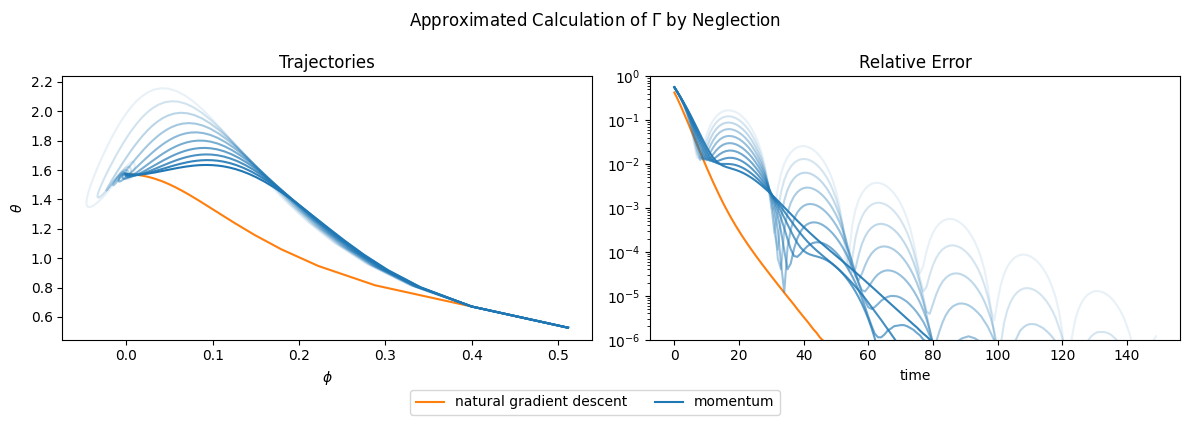

In [9]:
gammas_momentum = np.load("gammas_momentum_approx_approx.npy")
gammas_natural = np.load("gammas_natural_approx_approx.npy")
kappas = np.load("kappas_approx_approx.npy")

E_nat = calc_E(gammas_natural)
E_momentum = calc_E(gammas_momentum)
N = gammas_momentum.shape[0]
N_iter = gammas_natural.shape[0]
iter = jnp.arange(N_iter)
f, axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].plot(gammas_natural[:,1], gammas_natural[:, 0], color = "C1", label = "natural gradient descent")

for i in range(0, N):
    alpha = (i+1)/N

    if i == N-1:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", label = "momentum", alpha = alpha)

    else:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", alpha = alpha)

# axs[0].scatter(0, jnp.pi/2, color = "C3", marker = "o", zorder = 10)
# axs[0].set_ylim(0, jnp.pi)
# axs[0].set_xlim(-jnp.pi/3, 2/3*jnp.pi)
axs[0].set_ylabel("$\\theta$")
axs[0].set_xlabel("$\\phi$")
# axs[0].legend()
axs[0].set_title("Trajectories")

axs[1].plot(iter, E_nat+1, color = "C1")
for i in range(0, N):
    alpha = i/N*0.9 + 0.1
    axs[1].plot(iter, E_momentum[i]+1, color = "C0", label = "$\\kappa = $"+"{:.2f}".format(kappas[i]), alpha = alpha)

axs[1].set_yscale("log")
axs[1].set_title("Relative Error")
axs[1].set_ylim(1e-6,1)
axs[1].set_xlabel("time")

handles, labels = axs[0].get_legend_handles_labels()
f.legend(handles, labels, loc="lower center", ncol = 2, bbox_to_anchor = (0, -0.05, 1, 1))
f.suptitle("Approximated Calculation of $\\Gamma$ by Neglection")

f.tight_layout()

### No Use of $\Gamma$ at all

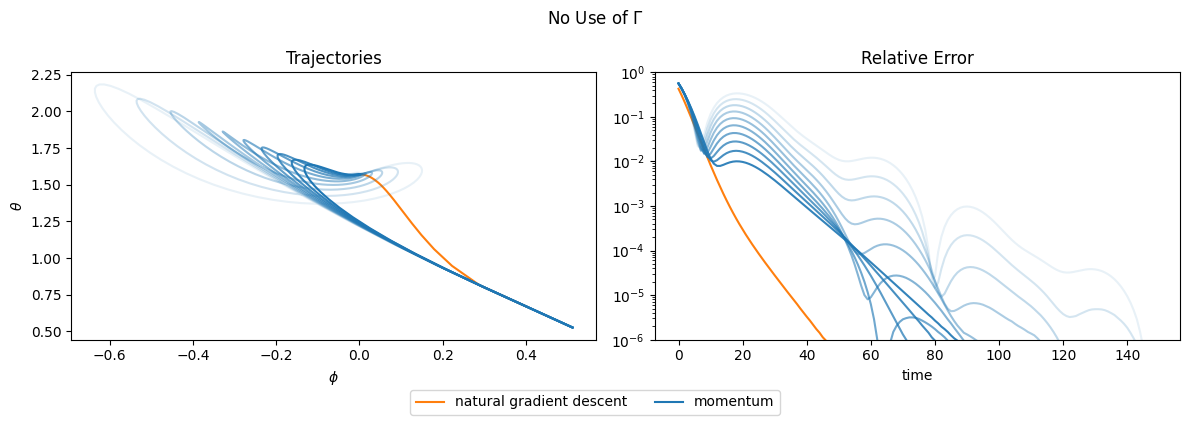

In [11]:
gammas_momentum = np.load("gammas_momentum_no_geodesic.npy")
gammas_natural = np.load("gammas_natural_no_geodesic.npy")
kappas = np.load("kappas_no_geodesic.npy")

E_nat = calc_E(gammas_natural)
E_momentum = calc_E(gammas_momentum)
N = gammas_momentum.shape[0]
N_iter = gammas_natural.shape[0]
iter = jnp.arange(N_iter)
f, axs = plt.subplots(1, 2, figsize = (12,4))
axs[0].plot(gammas_natural[:,1], gammas_natural[:, 0], color = "C1", label = "natural gradient descent")

for i in range(0, N):
    alpha = (i+1)/N

    if i == N-1:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", label = "momentum", alpha = alpha)

    else:
        axs[0].plot(gammas_momentum[i, :,1], gammas_momentum[i, :, 0], color = "C0", alpha = alpha)

# axs[0].scatter(0, jnp.pi/2, color = "C3", marker = "o", zorder = 10)
# axs[0].set_ylim(0, jnp.pi)
# axs[0].set_xlim(-jnp.pi/3, 2/3*jnp.pi)
axs[0].set_ylabel("$\\theta$")
axs[0].set_xlabel("$\\phi$")
# axs[0].legend()
axs[0].set_title("Trajectories")

axs[1].plot(iter, E_nat+1, color = "C1")
for i in range(0, N):
    alpha = i/N*0.9 + 0.1
    axs[1].plot(iter, E_momentum[i]+1, color = "C0", label = "$\\kappa = $"+"{:.2f}".format(kappas[i]), alpha = alpha)

axs[1].set_yscale("log")
axs[1].set_title("Relative Error")
axs[1].set_ylim(1e-6,1)
axs[1].set_xlabel("time")

handles, labels = axs[0].get_legend_handles_labels()
f.legend(handles, labels, loc="lower center", ncol = 2, bbox_to_anchor = (0, -0.05, 1, 1))
f.suptitle("No Use of $\\Gamma$")

f.tight_layout()